
# Predictive Models and Relationships

Explore correlations between annual salary and various customer attributes (e.g. age). These attributes could be those that are readily available in the data (e.g. age) or those that you construct or derive yourself (e.g. those relating to purchasing behaviour). Visualise any interesting correlations using a scatter plot.


Build a simple regression model to predict the annual salary for each customer using the attributes you identified above


How accurate is your model? Should ANZ use it to segment customers (for whom it does not have this data) into income brackets for reporting purposes?


For a challenge: 
- Build a decision-tree based model to predict salary.
- Does it perform better? How would you accurately test the performance of this model?

## 0. Importing Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime as dt
import seaborn as sns
import sklearn
from pycaret.regression import *
import sklearndf

plt.rcParams["figure.dpi"] = 300

## 1. Importing Data

In [2]:
df = pd.read_excel('ANZ synthesised transaction dataset.xlsx')

df.head() # sneak preview of the data


,status,card_present_flag,bpay_biller_code,account,currency,long_lat,txn_description,merchant_id,merchant_code,first_name,balance,date,gender,age,merchant_suburb,merchant_state,extraction,amount,transaction_id,country,customer_id,merchant_long_lat,movement
0,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,POS,81c48296-73be-44a7-befa-d053f48ce7cd,NaN,Diana,35.39,2018-08-01,F,26,Ashmore,QLD,2018-08-01T01:01:15.000+0000,16.25,a623070bfead4541a6b0fff8a09e706c,Australia,CUS-2487424745,153.38 -27.99,debit
1,authorized,0.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,830a451c-316e-4a6a-bf25-e37caedca49e,NaN,Diana,21.20,2018-08-01,F,26,Sydney,NSW,2018-08-01T01:13:45.000+0000,14.19,13270a2a902145da9db4c951e04b51b9,Australia,CUS-2487424745,151.21 -33.87,debit
2,authorized,1.0,NaN,ACC-1222300524,AUD,151.23 -33.94,POS,835c231d-8cdf-4e96-859d-e9d571760cf0,NaN,Michael,5.71,2018-08-01,M,38,Sydney,NSW,2018-08-01T01:26:15.000+0000,6.42,feb79e7ecd7048a5a36ec889d1a94270,Australia,CUS-2142601169,151.21 -33.87,debit
3,authorized,1.0,NaN,ACC-1037050564,AUD,153.10 -27.66,SALES-POS,48514682-c78a-4a88-b0da-2d6302e64673,NaN,Rhonda,2117.22,2018-08-01,F,40,Buderim,QLD,2018-08-01T01:38:45.000+0000,40.90,2698170da3704fd981b15e64a006079e,Australia,CUS-1614226872,153.05 -26.68,debit
4,authorized,1.0,NaN,ACC-1598451071,AUD,153.41 -27.95,SALES-POS,b4e02c10-0852-4273-b8fd-7b3395e32eb0,NaN,Diana,17.95,2018-08-01,F,26,Mermaid Beach,QLD,2018-08-01T01:51:15.000+0000,3.25,329adf79878c4cf0aeb4188b4691c266,Australia,CUS-2487424745,153.44 -28.06,debit


## 2. Missing Data Imputation

In [3]:
pd.DataFrame({'Missing values (%)':round(df.isnull().sum()/len(df.index)*100,2)})
# Some of the columns might need to be removed since they have more than 75% of the data missing

,Missing values (%)
status,0.00
card_present_flag,35.92
bpay_biller_code,92.65
account,0.00
currency,0.00
long_lat,0.00
txn_description,0.00
merchant_id,35.92
merchant_code,92.67
first_name,0.00


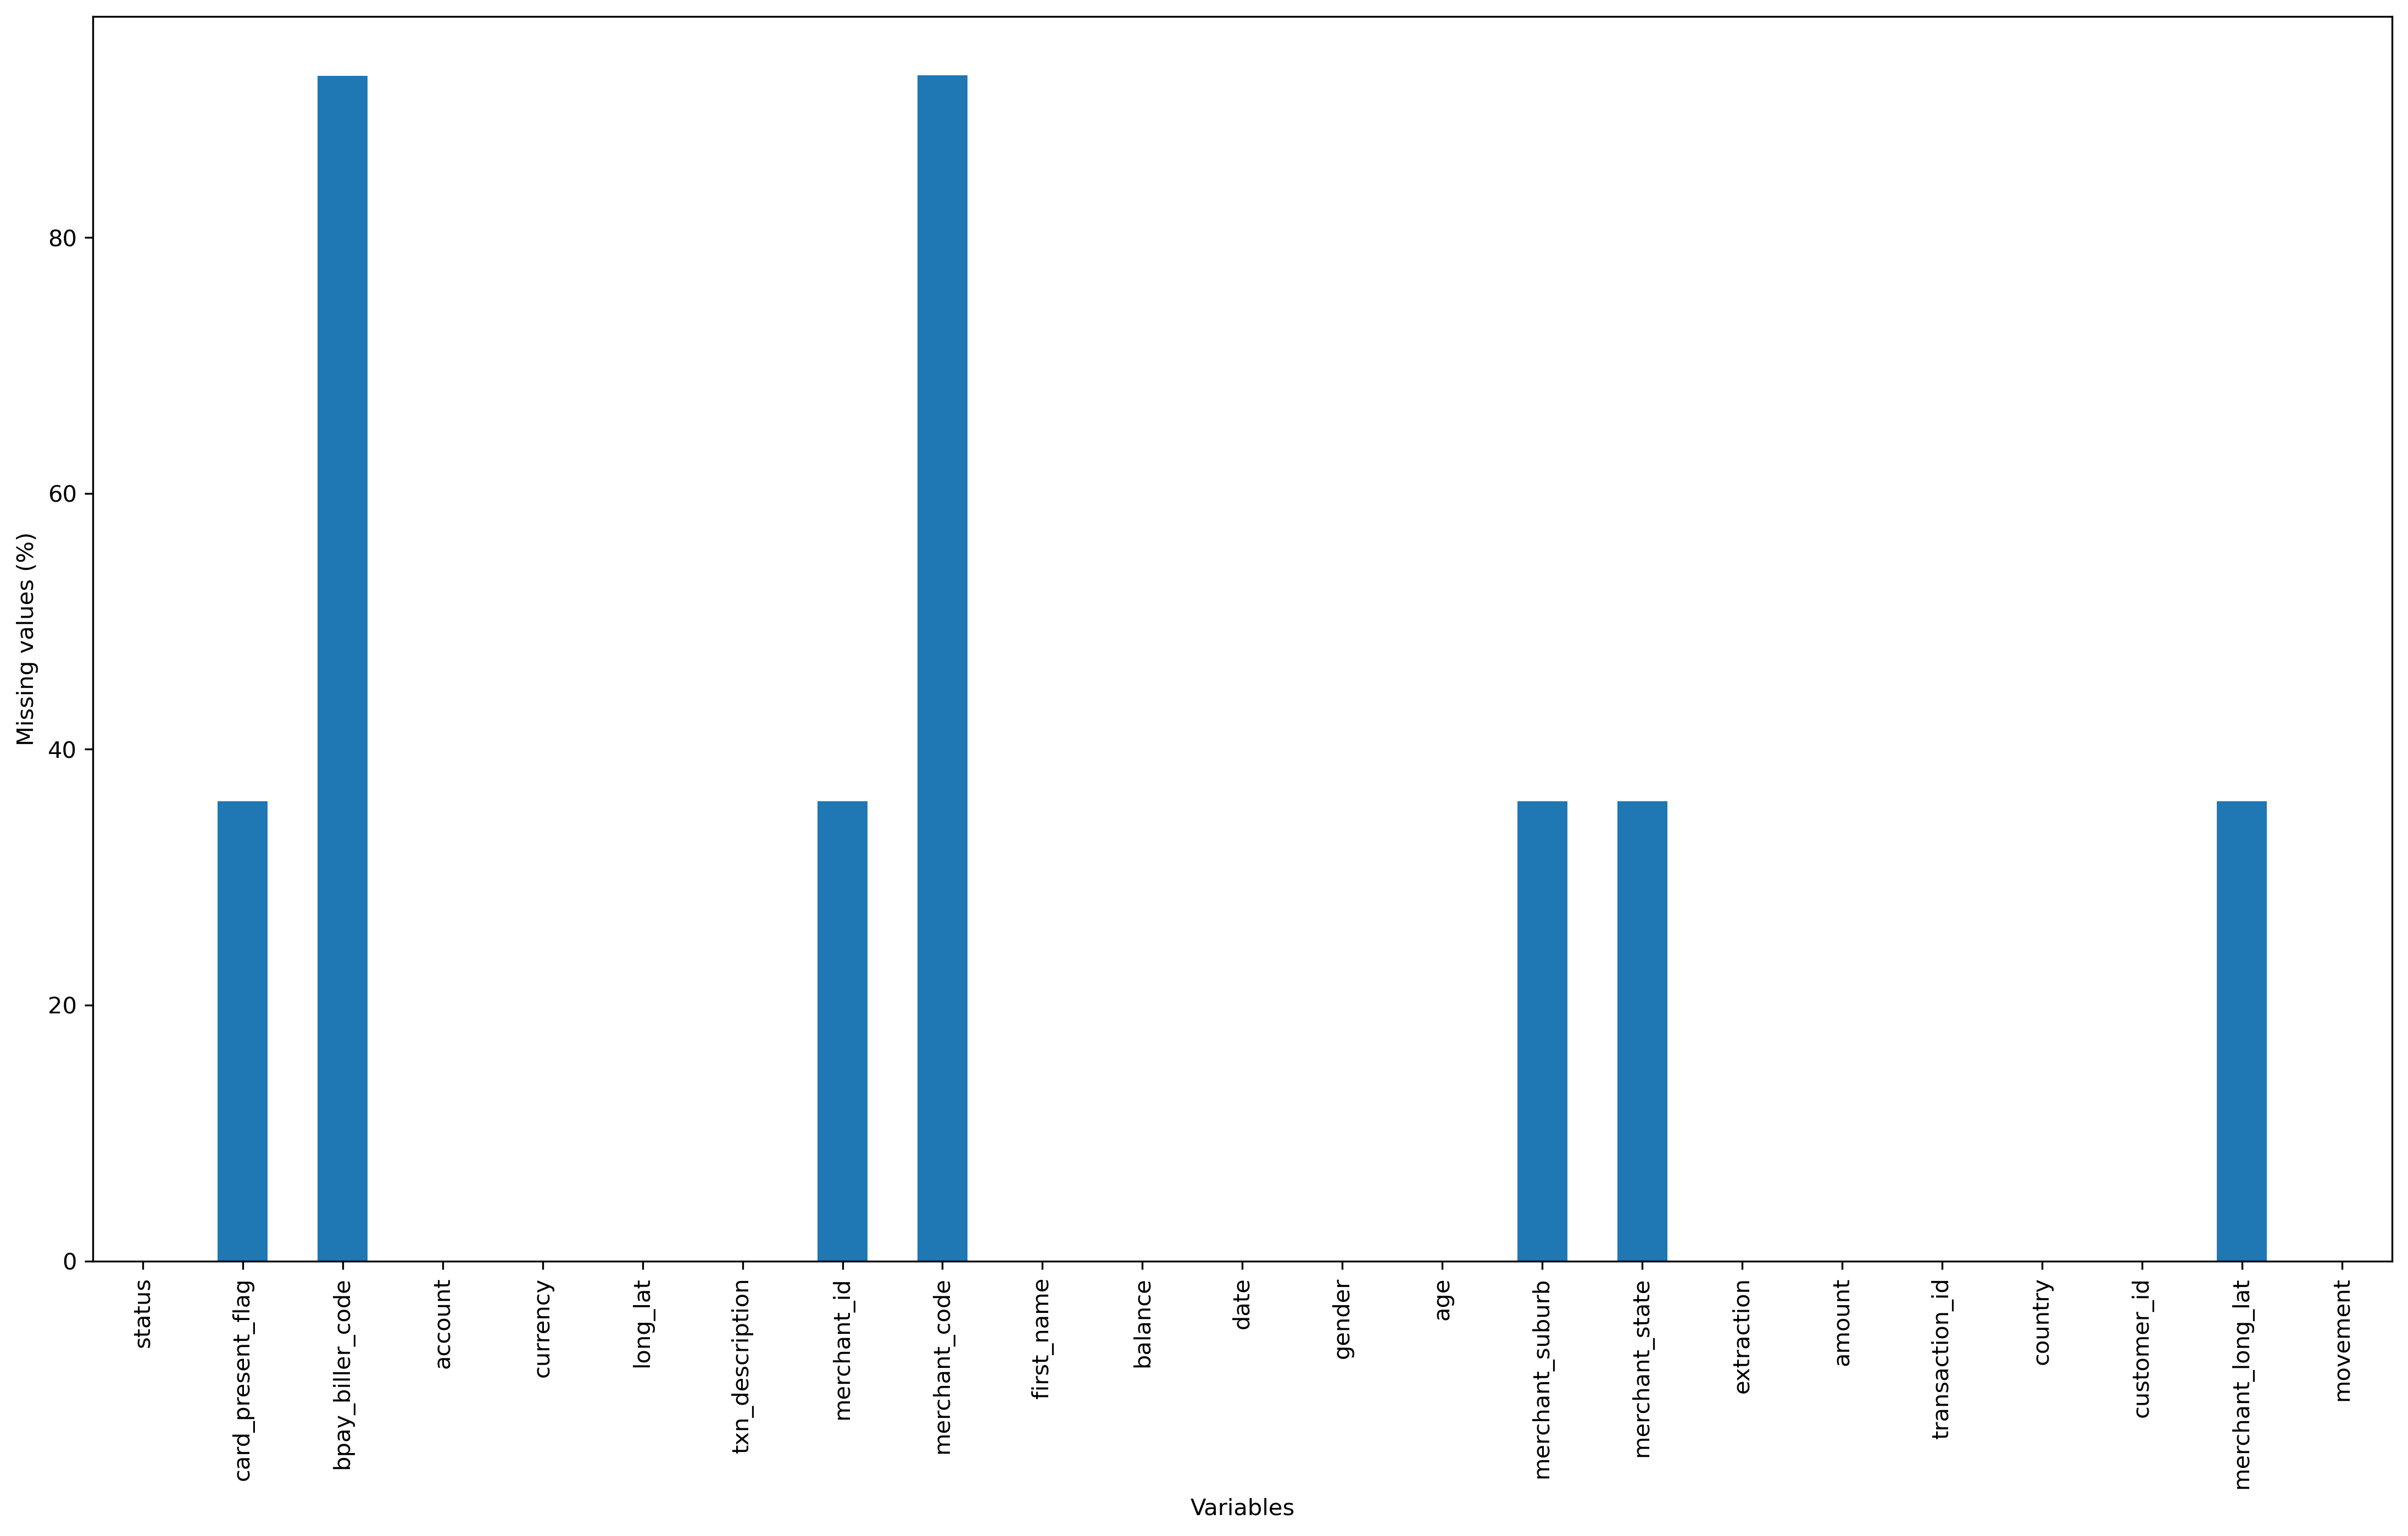

In [4]:
# Plot missing data
(df.isnull().sum()/len(df.index)*100).plot(kind="bar", figsize=(18,10))
# Set axis labels
plt.xlabel("Variables")
plt.ylabel("Missing values (%)")
#plt.savefig('missing.png', dpi=300)
plt.show()


In [5]:
def check_missing_over_30(df):
    '''
    A function to drop variables with missing values greater than 30%
    '''
    df1 = pd.DataFrame({"Missing values (%)":round(df.isnull().sum()/len(df), 2)})
    df1 = df1.loc[df1['Missing values (%)'] >= 0.30]
    list_rows = list(df1.index)
    df = df.drop(list_rows, axis = 1)
    return df

df1 = check_missing_over_30(df)

df1['date'] = pd.to_datetime(df1['date'], format = '%Y-%m-%d')

## 3. Feature Engineering

In [6]:
to_drop = ['currency', 'country', 'extraction', 'first_name']
df1 = df1.drop(to_drop, axis=1)

In [7]:
new = df1['long_lat'].str.split(" ", n=1, expand = True)
new = new.astype(float)

df1['lat'] = new[0]
df1['long'] = new[1]

print("Transaction is between", df1['date'].min(), "and", df1['date'].max())

Transaction is between 2018-08-01 00:00:00 and 2018-10-31 00:00:00


In [8]:
df1['month'] = df1['date'].dt.month_name()

Splitting data into 2 segments one which will be used for training and testing, the other will be kept unseen to the model

In [9]:
to_drop2 = ['transaction_id','customer_id', 'long_lat', 'txn_description','account']

data = df1.sample(frac=0.95, random_state=786)
data = data.drop(to_drop2, axis = 1)

data_unseen = df1.drop(data.index)
data_unseen = data_unseen.drop(to_drop2, axis = 1)

data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))



Data for Modeling: (11441, 10)
Unseen Data For Predictions: (602, 10)


## 4.0 Building a simple regression model to predict the annual salary for each customer

1. **Adjusted. R-squared** reflects the fit of the model. R-squared values range from 0 to 1, where a higher value generally indicates a better fit, assuming certain conditions are met. n our case we have an Adjusted R-squared of 7.3% which infers factors such as age, amount of transaction, longitude and latitude, gender and month of transaction explains 7.3% of the variation in a person's balance. Other factors which are not included in the model accounts for roughly 92%.

2. **Const coefficient** is our Y-intercept. It means that if the explanatory variables (age, amount, gender, etc) arre not in the model (that is their coefficients are zero), then the expected output (i.e., the balance) would be equal to the const coefficient. In other words, without the explanatory variables, the mean balance of 1202 AUD is the average balance for any customer.

3. **Age** coefficient represents the change in the balance due to a change of one unit in the age (everything else held constant). That is, if we increase a customer's age by 1, this leads to a 619 AUD increase in the customer's balance (everything else held constant).

4. **Amount** coefficient infers everything else held constant, a 1 AUD increase in amount of transaction leads to 6.7 AUD increase in a person's balance.

5. **Gender_F** coefficient infers everything else held constant, if the customer is a woman, the customer's average balance decreases by 1764 AUD.

6. **month_September** coefficient infers everythng else held constant, the transaction made in September does not hace any significant effect on a person's balance.

5. **std err reflects** the level of accuracy of the coefficients. The lower it is, the higher is the level of accuracy

6. **P >|t|** is our p-value. A p-value of less than 0.05 is considered to be statistically significant

7. **Confidence Interval** represents the range in which our coefficients are likely to fall (with a likelihood of 95%)


In [10]:
X = data.drop(['date', 'balance'], axis=1)

X = pd.get_dummies(X, columns = ['status','gender','movement', 'month'])

Y = data['balance']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                balance   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.073
Method:                 Least Squares   F-statistic:                     101.0
Date:                Sat, 30 Jan 2021   Prob (F-statistic):          1.31e-182
Time:                        17:11:12   Log-Likelihood:            -1.3428e+05
No. Observations:               11441   AIC:                         2.686e+05
Df Residuals:                   11431   BIC:                         2.687e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1203.2508   1202.15

## 5.0 Correlation between balance and other variables

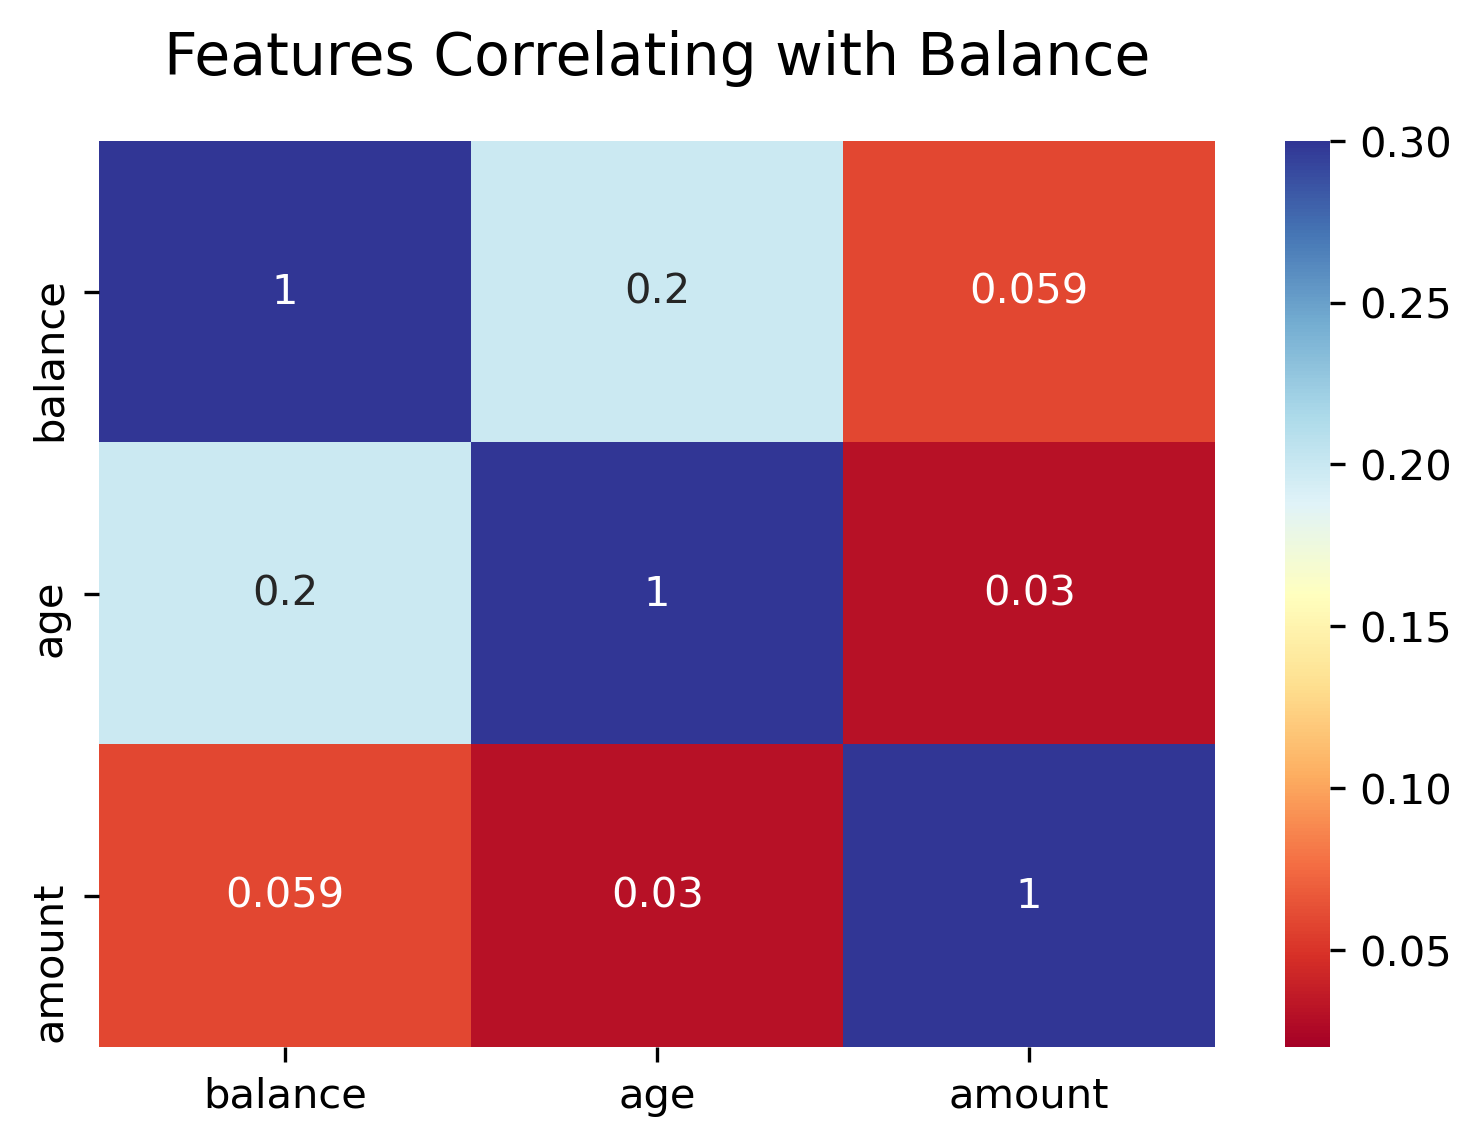

In [11]:
heatmap = sns.heatmap(df1[['balance','age','amount']].corr().sort_values(by='balance', ascending=False), vmin=0.02, vmax=0.3, annot=True, cmap='RdYlBu')
heatmap.set_title('Features Correlating with Balance', fontdict={'fontsize':14}, pad=16);

## 5.1 Fitting Regression Models and Selecting the Best Model

In [12]:
exp = pycaret.regression.setup(data, target = "balance", session_id=123,
                                  normalize = True, 
                                  transformation = True, 
                                  ignore_low_variance = True,
                                  remove_multicollinearity = True, multicollinearity_threshold = 0.9,
                                  date_features=['date'],
                                  feature_interaction = True,
                                  feature_selection = True
                                  )

,Description,Value
0,session_id,123
1,Target,balance
2,Original Data,"(11441, 10)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,4
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(8008, 27)"


In [13]:
best_model = compare_models(fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,1142.3196,2582713.4000,1606.5142,0.9973,0.5607,2.1527,2.3400
lightgbm,Light Gradient Boosting Machine,1168.8336,2733227.2395,1651.2279,0.9972,0.5543,2.2756,0.1880
catboost,CatBoost Regressor,1143.0081,2755930.2080,1658.8936,0.9971,0.5554,2.1692,4.8280
rf,Random Forest Regressor,1175.3730,3062315.9755,1745.9756,0.9968,0.5505,2.2659,2.6680
dt,Decision Tree Regressor,1318.4458,4045587.1779,2011.0527,0.9958,0.6842,2.1598,0.0700
et,Extra Trees Regressor,1440.5569,7666703.4598,2758.0317,0.9921,0.6087,2.5503,1.9700
gbr,Gradient Boosting Regressor,3623.5654,26270052.2907,5118.3684,0.9726,0.8329,5.2987,0.9380
ada,AdaBoost Regressor,9408.0135,130670362.6421,11422.3157,0.8634,1.4113,18.7241,0.3660
knn,K Neighbors Regressor,10077.9961,692530316.8000,26270.8691,0.2864,1.0637,9.7549,0.1460
lr,Linear Regression,14047.0787,898242150.4000,29925.3398,0.0769,1.4542,17.4919,1.6880


## 5.2 Evaluating the best parameters of the model

We see that the best model to predict a customer's balance is the **xgboost model** which is better than the decision model suggested in the quesetion. This is evident in all performance measures from Mean Absolute Error (MAE) to Root Mean Squared Error (RMSE).

Also it is better than the linear regression used earlier. For instance the linear regression had a R-square value of 7.3% whereas xgboost has 99.7%. This is a huge significant increase.

In [14]:
xg = create_model('xgboost', fold = 5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1137.7274,2553865.2500,1598.0818,0.9970,0.5987,3.7939
1,1148.7706,2588419.0000,1608.8564,0.9969,0.5694,1.9633
2,1105.5607,2344473.5000,1531.1674,0.9976,0.5200,2.3601
3,1154.5085,2731094.7500,1652.6024,0.9976,0.5845,1.6891
4,1165.0308,2695714.5000,1641.8632,0.9975,0.5311,0.9574
Mean,1142.3196,2582713.4000,1606.5142,0.9973,0.5607,2.1527
SD,20.3877,135947.9998,42.7257,0.0003,0.0304,0.9398


In [15]:
tuned_xgb = tune_model(xg, fold = 5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,1165.3097,3457836.5000,1859.5259,0.9960,0.5963,2.9637
1,1189.5276,2828306.0000,1681.7568,0.9966,0.5770,1.8553
2,1113.7053,2336129.5000,1528.4402,0.9976,0.5267,3.6911
3,1147.6582,2614952.0000,1617.0813,0.9977,0.5639,1.6961
4,1209.3044,2907128.2500,1705.0303,0.9973,0.5233,0.9533
Mean,1165.1010,2828870.4500,1678.3669,0.9970,0.5574,2.2319
SD,33.1554,371558.2433,109.3389,0.0006,0.0285,0.9725


## 5.3 Feature Importance Plot

According to the the XGBOOST model, the most important features for having high customer's balance are:

- Being a man
- Age
- Location (longitude and latitude)

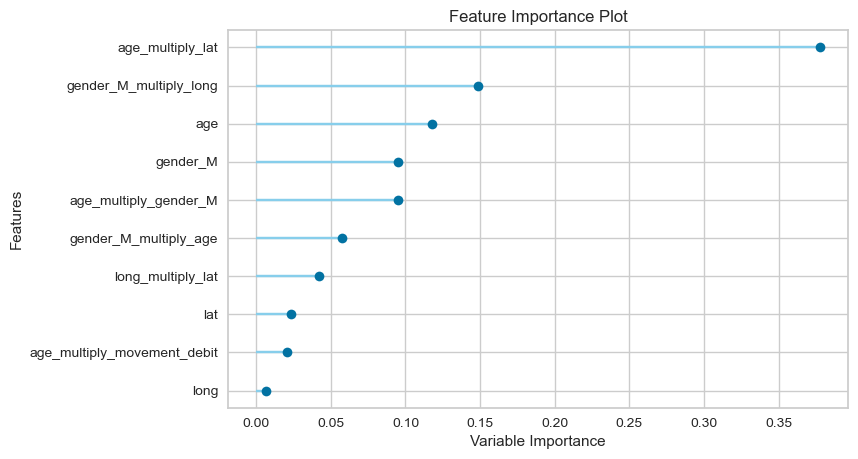

In [16]:
plot_model(tuned_xgb, plot='feature')

## 5.4 Predict on test / hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. 30% of the data has been separated out as test/hold-out sample. All of the evaluation metrics we have seen above are cross validated results based on the training set (70%) only. Now, using our final trained model stored in the tuned_rf variable we will predict against the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [17]:
predict_model(tuned_xgb)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,1131.8994,3067309.7500,1751.3737,0.9970,0.4638,1.4016


,date_month_10,date_weekday_3,date_weekday_2,date_month_9,movement_debit,status_posted,date_is_month_start_0,date_weekday_0,lat,amount,...,age_multiply_gender_M,movement_debit_multiply_amount,age_multiply_date_is_month_start_0,gender_M_multiply_age,long_multiply_lat,age_multiply_movement_debit,gender_M_multiply_long,age_multiply_lat,balance,Label
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.145061,-0.590101,...,-0.333269,-0.590101,-0.333269,-0.333269,-0.090879,-0.333269,-0.626490,-0.048344,11228.599609,10051.881836
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.645229,-0.069175,...,0.821777,-0.069175,0.821777,0.821777,0.394688,0.821777,0.611702,0.530234,2527.020020,3618.354004
2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.516511,1.785416,...,-0.937946,1.785416,-0.937946,-0.937946,-0.106908,-0.937946,-0.206981,-0.484459,6666.479980,6191.145996
3,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.514187,2.580363,...,0.000000,0.000000,0.972688,0.000000,-0.098337,0.000000,-0.000000,0.500143,8754.759766,10557.691406
4,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.396260,0.183759,...,-0.000000,0.183759,-0.333269,-0.000000,-0.130695,-0.333269,-0.000000,-0.132061,5935.089844,6701.763672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3428,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,-1.925875,-0.506331,...,-0.000000,-0.506331,-0.197416,-0.000000,-0.068233,-0.197416,0.000000,0.380199,4989.779785,5184.313965
3429,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.161827,-0.627031,...,1.244979,-0.627031,1.244979,1.244979,-0.103869,1.244979,-0.641848,0.201471,15358.509766,14559.458984
3430,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.145061,-0.760585,...,0.000000,-0.760585,0.898652,0.000000,-0.092663,0.898652,-0.000000,0.130360,20439.429688,19818.455078
3431,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.078661,0.106661,...,0.000000,0.106661,1.044134,0.000000,-0.049038,1.044134,-0.000000,0.082133,196288.468750,197800.812500


The MAE on test/hold-out set is 1185 AUD compared to the average MAE after 5 CVs on the train set is 1237 AUD.

This is not a significant differen. If there is a large variation between the test/hold-out and CV results, then this would normally indicate over-fitting but could also be due to several other factors and would require further investigation. In this case, we will move forward with finalizing the model and predicting on unseen data (the 5% that we had separated in the beginning and never exposed to training).

## 5.5 Finalize Model for Deployment

Model finalization is the last step in the experiment. I started the machine learning workflow in with setup(), followed by comparing all models and shortlisting a few candidate models.

This workflow will eventually lead to selecting random forest as the best model for use in making predictions on new and unseen data.

The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [18]:
final_xgb = finalize_model(tuned_xgb)

## 5.6 Predict on unseen data

The predict_model() function is also used to predict on the unseen dataset. The only difference from the above is that this time we will pass the data_unseen parameter. data_unseen is the variable created at the beginning and contains 5% of the original dataset which was never exposed to training.

Label is the **balance predicted** from the XGBOOST model

In [19]:
unseen_predictions = predict_model(final_xgb, data=data_unseen)
unseen_predictions.head()

,status,balance,date,gender,age,amount,movement,lat,long,month,Label
0,posted,1705.43,2018-08-01,M,20,163.00,debit,151.22,-33.87,August,1186.113647
1,posted,38.31,2018-08-01,F,47,58.00,debit,115.72,-32.28,August,3197.970215
2,authorized,38.42,2018-08-01,F,18,36.28,debit,153.09,-27.48,August,-754.278015
3,authorized,49756.21,2018-08-01,M,78,25.70,debit,145.09,-37.82,August,48477.761719
4,authorized,58154.74,2018-08-01,M,33,17.97,debit,145.13,-37.70,August,60247.996094


## 5.7 Saving the model

In [20]:
save_model(final_xgb,'Final XGB Model 30Jan2020')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='balance',
                                       time_features=['date'])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_st...
                               interaction_constraints='', learning_rate=0.439,
                               max_delta_step=0, max_depth=8, min_child_weight=2,
                               missing=nan, monotone_constraints='()',
                               n_estimators=20, n_jobs=-1, num_parallel_tree=1,


In [21]:
final_xgb

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.439, max_delta_step=0, max_depth=8,
             min_child_weight=2, missing=nan, monotone_constraints='()',
             n_estimators=20, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=123, reg_alpha=10,
             reg_lambda=0.1, scale_pos_weight=1.4, subsample=0.9,
             tree_method='auto', validate_parameters=1, verbosity=0)

In [22]:
data_predictions = predict_model(final_xgb, data = data)
data_predictions.head()

,status,balance,date,gender,age,amount,movement,lat,long,month,Label
0,authorized,16082.36,2018-09-04,M,42,29.50,debit,149.03,-35.25,September,16343.770508
1,posted,4621.40,2018-09-06,M,21,35.00,debit,147.08,-37.97,September,5844.497070
2,authorized,3529.55,2018-09-08,M,37,121.58,debit,153.32,-27.93,September,4168.582031
3,authorized,6987.96,2018-09-05,F,19,18.89,debit,144.66,-37.91,September,10035.182617
4,posted,9842.58,2018-10-11,F,25,131.00,debit,150.50,-23.40,October,10389.291992
